## **Instaling and importing libraries**

In [ ]:
pip install pyswarm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from pyswarm import pso
import math
import keras

## **Importing data, and getting close price from it**

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HDFCBANK.csv')

In [ ]:
df

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,HDFCBANK,EQ,157.40,166.00,170.00,166.00,170.00,170.00,169.52,33259,5.638122e+11,NaN,NaN,NaN
1,2000-01-04,HDFCBANK,EQ,170.00,182.00,183.45,171.00,174.00,173.80,174.99,168710,2.952261e+12,NaN,NaN,NaN
2,2000-01-05,HDFCBANK,EQ,173.80,170.00,173.90,165.00,168.00,166.95,169.20,159820,2.704094e+12,NaN,NaN,NaN
3,2000-01-06,HDFCBANK,EQ,166.95,168.00,170.00,165.30,168.95,168.30,168.44,85026,1.432166e+12,NaN,NaN,NaN
4,2000-01-07,HDFCBANK,EQ,168.30,162.15,171.00,162.15,170.75,168.35,166.79,85144,1.420158e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5301,2021-04-26,HDFCBANK,EQ,1414.15,1413.00,1429.00,1402.75,1407.55,1404.80,1413.19,15085476,2.131861e+15,291268.0,9791881.0,0.6491
5302,2021-04-27,HDFCBANK,EQ,1404.80,1407.25,1442.00,1404.80,1435.05,1438.70,1430.40,10296453,1.472810e+15,233200.0,5650216.0,0.5488
5303,2021-04-28,HDFCBANK,EQ,1438.70,1436.25,1479.00,1431.00,1475.00,1476.80,1463.19,12051970,1.763438e+15,197146.0,7196647.0,0.5971
5304,2021-04-29,HDFCBANK,EQ,1476.80,1486.20,1503.65,1461.00,1471.65,1472.50,1481.15,12039276,1.783196e+15,252296.0,4818551.0,0.4002


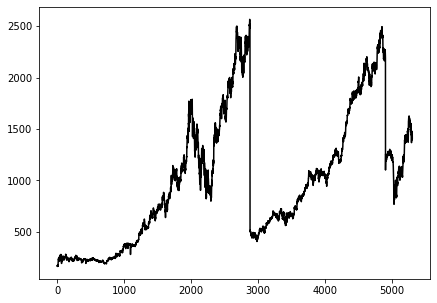

In [ ]:
data = df.filter(['Close'])
dataset = data.values
plt.figure(figsize=(7,5))
plt.plot(dataset, color= "black")

# **Neural networks forecasting**

### Prepering data

In [ ]:
training_data_len = 2000

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [ ]:
train_data = scaled_data[0:training_data_len , :]
x_train =[]
y_train =[]
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

In [ ]:
x_train = np.array(x_train)
y_train= np.array(y_train)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [ ]:
test_data= scaled_data[1960:, :]

In [ ]:
x_test = []
y_test = dataset[2020:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [ ]:
x_test = np.array(x_test)
x_test =np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))


### Using GridSearch to find best parameters for neural network

In [ ]:
def create_model():
  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(25))
  model.add(Dense(1))
  model.compile(loss='mse', metrics=[keras.metrics.MeanSquaredError()])
  return model

In [ ]:
model = KerasRegressor(build_fn=create_model, verbose=0)
epochs = [1,2,3]
batch_size = [2, 4, 1]
param_grid = dict(epochs=epochs, batch_size=batch_size)

In [ ]:
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)
# grid_result = grid.fit(x_train, y_train, validation_data=(x_test,y_test))

In [ ]:
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# best_batch_size = grid_result.best_params_['batch_size']
# best_epochs = grid_result.best_params_['epochs']
best_batch_size = 3
best_epochs = 2


### Creating model with best parameters, ploting result and calculating mean squared error

In [ ]:
  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(25))
  model.add(Dense(1))
  model.compile(loss='mse', metrics=[keras.metrics.MeanSquaredError()])

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs = best_epochs, verbose=1, batch_size=best_batch_size)

Epoch 1/2
647/647 [==============================] - 40s 56ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 2046044.7500 - val_mean_squared_error: 2046044.7500
Epoch 2/2
647/647 [==============================] - 35s 54ms/step - loss: 4.0319e-04 - mean_squared_error: 4.0319e-04 - val_loss: 2046137.6250 - val_mean_squared_error: 2046137.6250


In [ ]:
predictions = model.predict(x_test)

In [ ]:
predictions =scaler.inverse_transform(predictions)

30.366729530153375

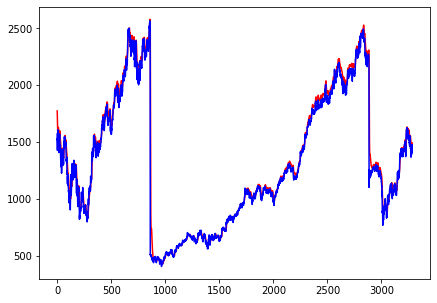

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(predictions, color= "r")
plt.plot(y_test, color= "b")
rmse = np.sqrt( np.mean(predictions - y_test)**2)
rmse

# Using created model to predict data in a further range

In [ ]:
x=0
val = y_test[x:x+300,:]
val = scaler.fit_transform(val)
price = val[0:60,:]
priceR = price
for i in range(60,300):
  priceR = np.concatenate((priceR,np.array(model.predict(np.reshape(priceR[i-60:i,0],(1,60,1))))))

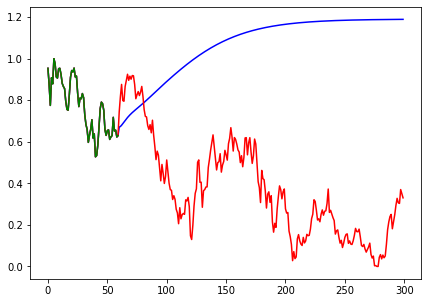

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(priceR, color= "b")
plt.plot(val, color="r")
plt.plot(price, color="g")

### Unscaling data so we can calculate mean squared error

---



In [ ]:
r_val = scaler.inverse_transform(val)
r_priceR = scaler.inverse_transform(priceR)
r_price = scaler.inverse_transform(price)

454.6479621883633

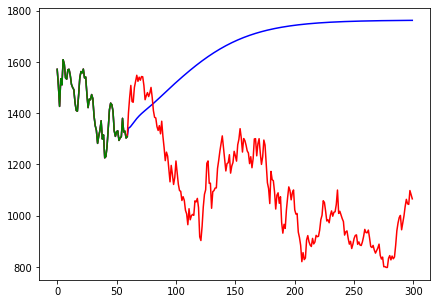

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(r_priceR, color= "b")
plt.plot(r_val, color="r")
plt.plot(r_price, color="g")
np.sqrt( np.mean(r_priceR-r_val)**2)

# **Forecasting parameters of data in Black Sholes model using PSO**

In [ ]:
A = y_test[x:x+60,:]
C = y_test[x:x+300, :]

In [ ]:
def error(x):
    S0 = A[0]
    np.random.seed(2237)
    r, sigma = x[0],x[1]
    A0 = A[0]
    M = 60
    T= 1/6
    I= 300
    dt = T/M
    S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt
    + sigma * math.sqrt(dt)
    * np.random.standard_normal((M + 1, I)), axis=0))
    B=A.copy()
    for i in range (0,M):
      B[i]=np.mean(S[i])
    return np.sqrt( np.mean(A - B)**2)

In [ ]:
lb = [-3,-3]
ub = [2,2]

In [ ]:
xopt, fopt = pso(error, lb, ub)
[xopt,fopt]

Stopping search: Swarm best objective change less than 1e-08


[array([-1.18034415,  0.53094329]), 2.4984766848016684e-09]

In [ ]:
def error_plot_extended(x, plot):
    np.random.seed(2237)
    S0 = A[0]
    r, sigma = x[0],x[1]
    A0 = A[0]
    M = 300
    T= 5/6
    I= 200
    dt = T/M
    S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt
    + sigma * math.sqrt(dt)
    * np.random.standard_normal((M + 1, I)), axis=0))
    B=C.copy()
    for i in range (0,M):
      B[i]=np.mean(S[i])
    B_pred = B[60:,:]
    C_pred = C[60:,:]
    B_plot = B[:60,:]
    C_plot = C[:60,:]
    if plot == 1:
      plt.figure(figsize=(8,5))
      plt.plot(B, color= "b" ,label="Black Sholes model prediction")
      plt.plot(C, color="r", label="Real Data")
      plt.plot(B_plot, color= "y")
      plt.plot(C_plot, color="g")
      plt.title(np.sqrt( np.mean(C_pred - B_pred)**2))
      plt.legend()
    return np.sqrt( np.mean(C_pred - B_pred)**2)

227.55525088872056

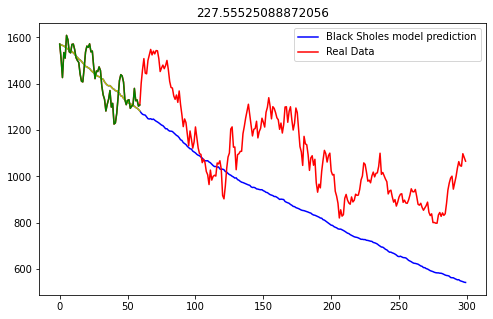

In [ ]:
error_plot_extended(xopt, 1)

# **Comparing two models**

### Fuctions which will calculate error

In [ ]:
def neural_error(starting_point, plot):
  val = y_test[starting_point:starting_point+300,:]
  val = scaler.fit_transform(val)
  price = val[0:60,:]
  priceR = price
  for i in range(60,300):
    priceR = np.concatenate((priceR,np.array(model.predict(np.reshape(priceR[i-60:i,0],(1,60,1))))))
  r_val = scaler.inverse_transform(val)
  r_priceR = scaler.inverse_transform(priceR)
  r_price = scaler.inverse_transform(price)
  if plot == 1:
    plt.figure(figsize=(8,5))
    plt.plot(r_priceR, color= "b" , label="Neural network prediction")
    plt.plot(r_val, color="r", label="Real data")
    plt.plot(r_price, color="g")
    plt.xlabel('Time in days')
    plt.ylabel('Call Price')
    plt.title( np.sqrt( np.mean(r_priceR-r_val)**2))
    plt.legend()
  return np.sqrt( np.mean(np.abs(r_priceR-r_val))**2)

In [ ]:
def BS_error(starting_point, plot):
  xopt, fopt = pso(error, lb, ub)
  bs_error = error_plot_extended(xopt, plot)
  return bs_error

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Total error in neural network model prediction =  1490.9907839869174
Total error in Black Sholes model prediction =  3139.718494212247


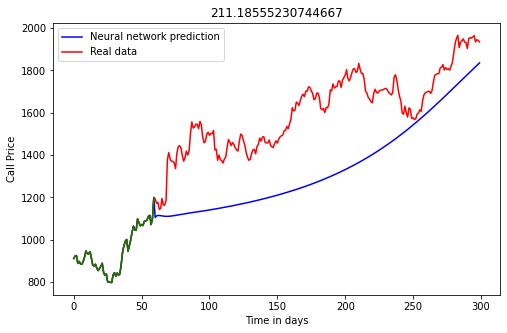

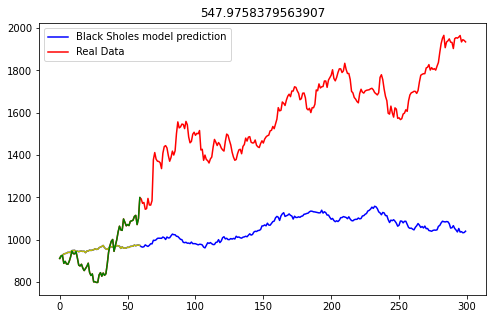

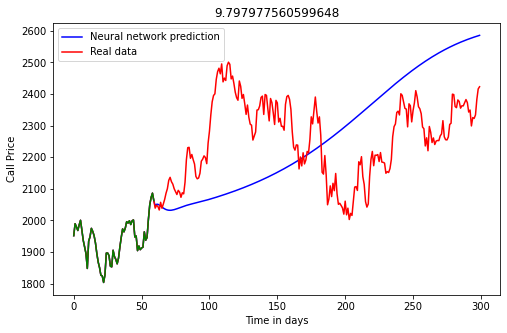

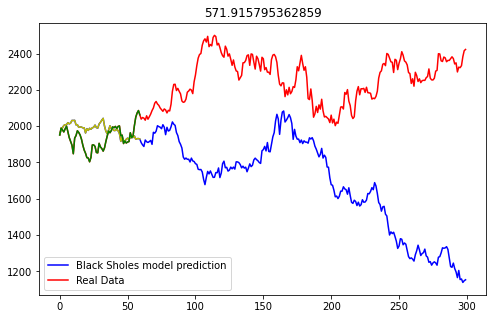

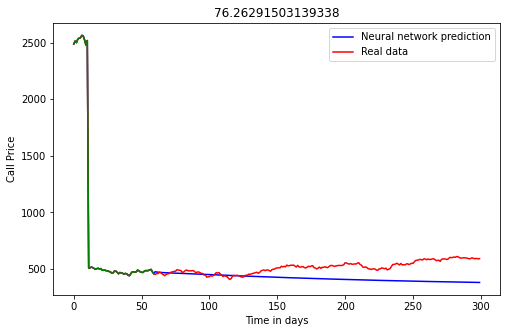

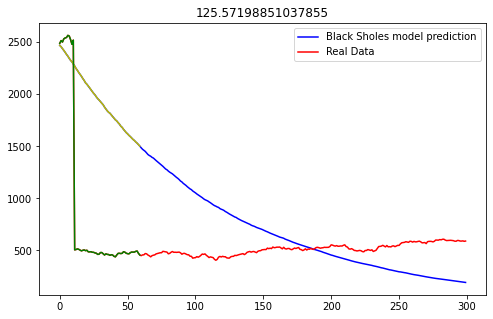

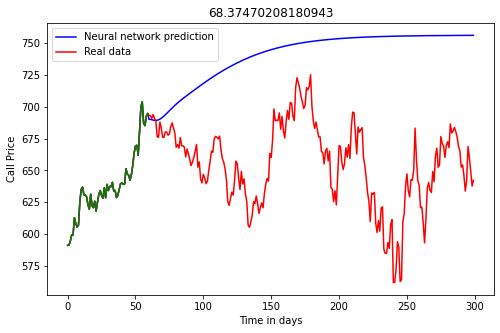

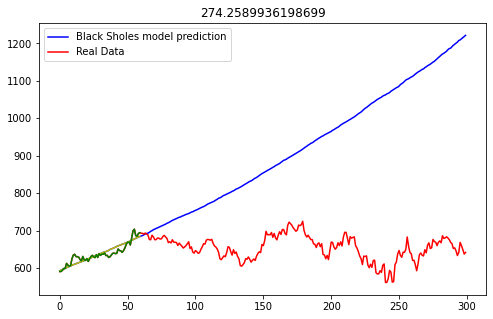

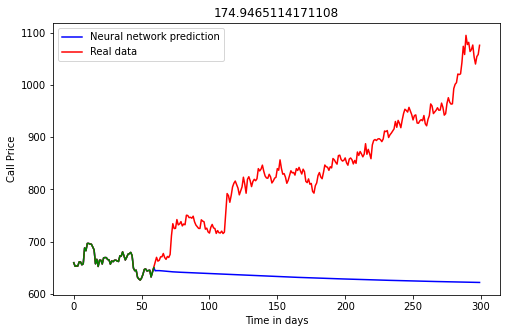

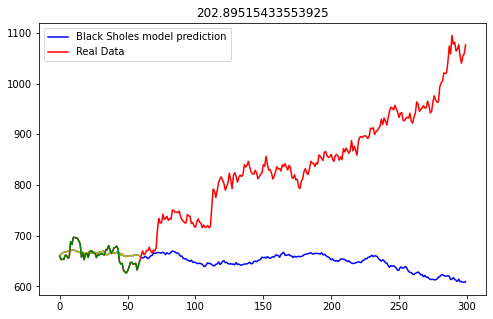

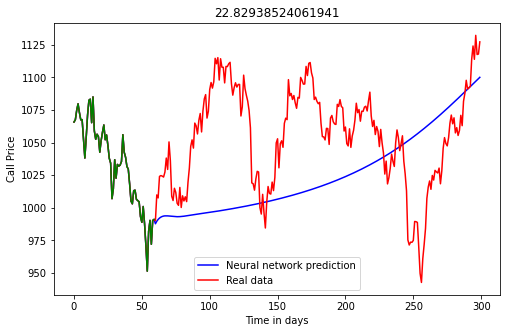

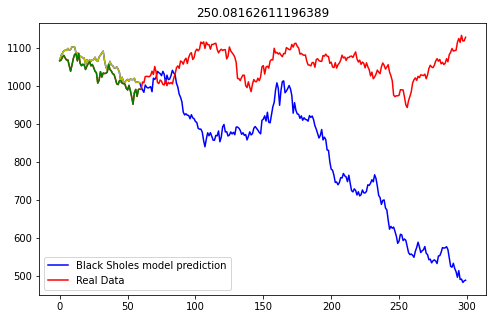

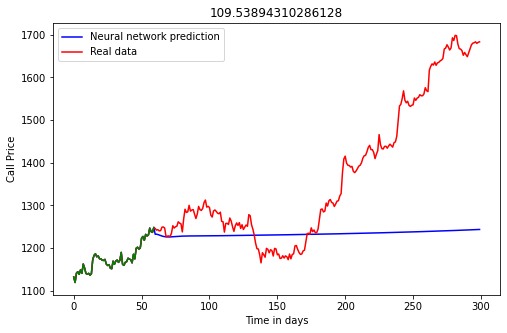

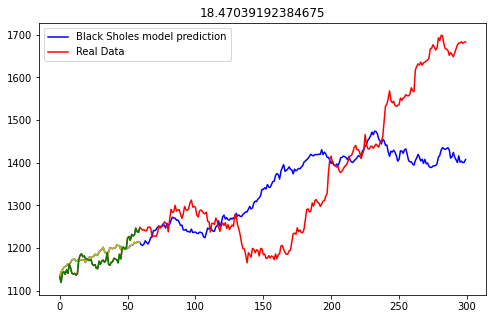

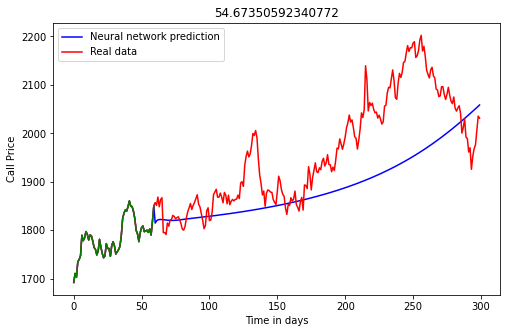

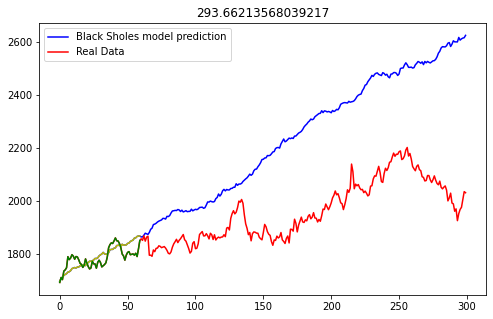

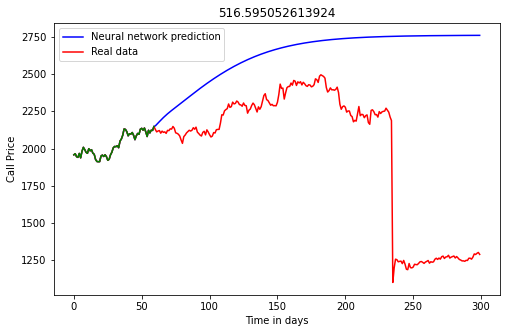

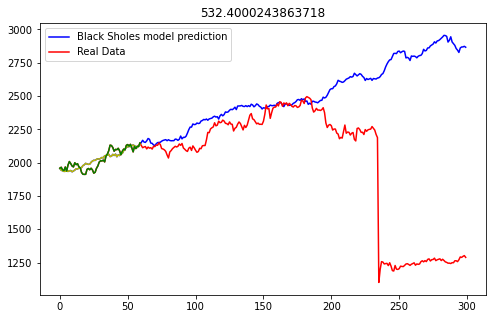

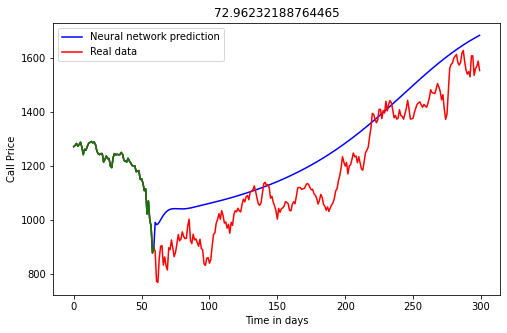

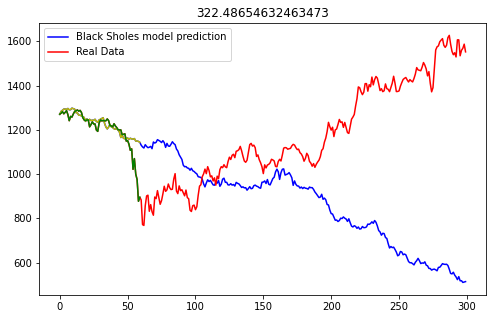

In [ ]:
total_n_error = 0
total_bs_error = 0
for starting_point in range(250, 3000, 300):
    total_n_error += neural_error(starting_point,1)
    A = y_test[starting_point:starting_point+60,:]
    C = y_test[starting_point:starting_point+300, :]
    total_bs_error += BS_error(starting_point,1)
print ("Total error in neural network model prediction = ", total_n_error)
print ("Total error in Black Sholes model prediction = ", total_bs_error)